In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/community-alignment-graph/subreddit_edges9.txt
/kaggle/input/news-source-credibility/news_source_crediblity.csv


In [2]:
!conda install -y gdown
!gdown --id 1DPugNEGWNlLp8accR8blzkQxd732DgDv
!gdown --id 1kgZu_jp2iEEaWbm7Qcr2W2axcCd6LbrZ
!gdown --id 1_Tqfzo07MG6bOKuUmaVTEetd11GJb1oY
!gdown --id 1PeoiZZ_CA4Blq0pjCGbAxYkNBi5Syi7c
!gdown --id 1AC325OU8dqk0seehIgSToh3svXSeapnl
!gdown --id 18roQi1kYOIroMEznheJr1naGvmRjoCGN
!gdown --id 1_9YJt4uj2so90YDTfbndlaY37JQGALyN
!gdown --id 1-T1gaHrOLO_FwsIoidUeLSFuwWpPBpch
!gdown --id 1G6Pyq5eF44nzO0RcbbnNQsrnC_1OiOwZ
!gdown --id 181JIjGEoEyvETQ6xGeq-cXj4GmztZPIK
!gdown --id 1pI3K9Hf6qdDi8L0W547Px52MNAaYxOsl
!gdown --id 1gHMuihxx7f6-shp1y8XVOwUJkQqBXi_v
!gdown --id 1nK4wDYqEWXiwcnXU35lqditT7Qeml4xV
!gdown --id 1AFcFDhtqyXKLICitV9jxuQzIdHUrhWTz
!gdown --id 1EFRgk6Ja2LfS9AC-Tr_qhBlYngKA5nKK
!gdown --id 1n6tNedJrWbt9vJ81CneEp5_CbNBH4QyW

warning  libmamba Cache file "/opt/conda/pkgs/cache/c7b05ae9.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/758dc0ed.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/eab6ca9b.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/6d94291a.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/3864cda3.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/47534735.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/88ec62ec.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/eb045dd1.json" was modified by another program
[+] 0.0s
[+] 0.1s
nodefaults/linux-64 (check zst) ━━━━━━━━━━━━━━╸━━━━━━━━━━   0.0 B Checking  0.1s
nodefaults/noarch (check zst)   ━━━━━━━━━╸━━━━━━━━━━━━━━━   0.0 B Checking  0.0s
nvidia/linux-64 (check zst) 

# Determine Initial Susceptibility Values

In [3]:
import pandas as pd
import glob

# Load all files dynamically
submission_files = glob.glob('*_submissions.csv')  # Matches all *_submissions.csv files
comment_files = glob.glob('*_comments.csv')        # Matches all *_comments.csv files

# Load news source credibility data
news_source_credibility = pd.read_csv('/kaggle/input/news-source-credibility/news_source_crediblity.csv')  # Contains `Node` and `Average Weight`

In [4]:
# Combine all submissions into a single DataFrame
submissions = pd.concat(
    [pd.read_csv(file).assign(subreddit=file.split('_')[0]) for file in submission_files],
    ignore_index=True
)

# Combine all comments into a single DataFrame
comments = pd.concat(
    [pd.read_csv(file).assign(subreddit=file.split('_')[0]) for file in comment_files],
    ignore_index=True
)

# Merge submissions with news source credibility
submissions = submissions.merge(
    news_source_credibility, 
    how='left', 
    left_on='domain', 
    right_on='Node'
)

/tmp/ipykernel_24/2720803507.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(file).assign(subreddit=file.split('_')[0]) for file in submission_files],
/tmp/ipykernel_24/2720803507.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(file).assign(subreddit=file.split('_')[0]) for file in submission_files],


In [5]:
# Calculate interaction weight as the number of comments for each submission
submissions['interaction_weight'] = submissions['num_comments']

# Aggregate interactions by subreddit and domain
interaction_weights = submissions.groupby(['subreddit', 'domain']).agg(
    total_comments=('interaction_weight', 'sum'),
    mention_count=('id', 'count'),
    reliability_score=('Average Weight', 'first')  # Assume consistent reliability score per domain
).reset_index()

# Compute weighted reliability
interaction_weights['weighted_reliability'] = (
    interaction_weights['total_comments'] * interaction_weights['reliability_score']
)

In [61]:
# Aggregate reliability scores by subreddit
subreddit_scores = interaction_weights.groupby('subreddit').apply(
    lambda group: group['weighted_reliability'].sum() / group['total_comments'].sum()
).reset_index()
subreddit_scores.rename(columns={0: 'initial_misinformation_susceptibility_score'}, inplace=True)

# Calculate the mean initial score across all subreddits
mean_score = subreddit_scores['initial_misinformation_susceptibility_score'].mean()

# Exclude pre-defined subreddits from an initial susceptibility score
subreddit_scores.loc[subreddit_scores['subreddit'] == 'progressive', 'initial_misinformation_susceptibility_score'] = mean_score
subreddit_scores.loc[subreddit_scores['subreddit'] == 'socialism', 'initial_misinformation_susceptibility_score'] = mean_score
subreddit_scores.loc[subreddit_scores['subreddit'] == 'energy', 'initial_misinformation_susceptibility_score'] = mean_score

# Save subreddit scores
subreddit_scores.to_csv('subreddit_initial_scores.csv', index=False)
print("Subreddit initial scores saved as 'subreddit_initial_scores.csv'")

Subreddit initial scores saved as 'subreddit_initial_scores.csv'


/tmp/ipykernel_24/3430968798.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subreddit_scores = interaction_weights.groupby('subreddit').apply(


# Incorporate Susceptibility from Connected Subreddits

In [82]:
import pandas as pd
import networkx as nx
import numpy as np

# Load the subreddit alignment graph
edges = pd.read_csv('/kaggle/input/community-alignment-graph/subreddit_edges9.txt', sep=',', names=['node1', 'node2', 'alignment'])

# Load initial subreddit scores
initial_scores = pd.read_csv('subreddit_initial_scores.csv')
initial_scores = dict(zip(initial_scores['subreddit'], initial_scores['initial_misinformation_susceptibility_score']))

In [83]:
# Create the graph
G = nx.Graph()

# Calculate the total weight of connections for each node
edge_weights = edges.groupby('node1')['alignment'].sum().to_dict()

# Add edges with normalized alignment weights
for _, row in edges.iterrows():
    node1, node2, alignment = row['node1'], row['node2'], row['alignment']
    total_weight = edge_weights.get(node1, 1)  # Prevent division by zero
    normalized_weight = alignment / total_weight
    G.add_edge(node1, node2, weight=normalized_weight)

# Initialize node scores
for node in G.nodes:
    G.nodes[node]['score'] = initial_scores.get(node, 0.0)  # Default to 0.0 for nodes without initial scores

## Print the initial susceptibility value graph

/tmp/ipykernel_24/2746192810.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Initial Misinformation Susceptibility Score', shrink=0.9)


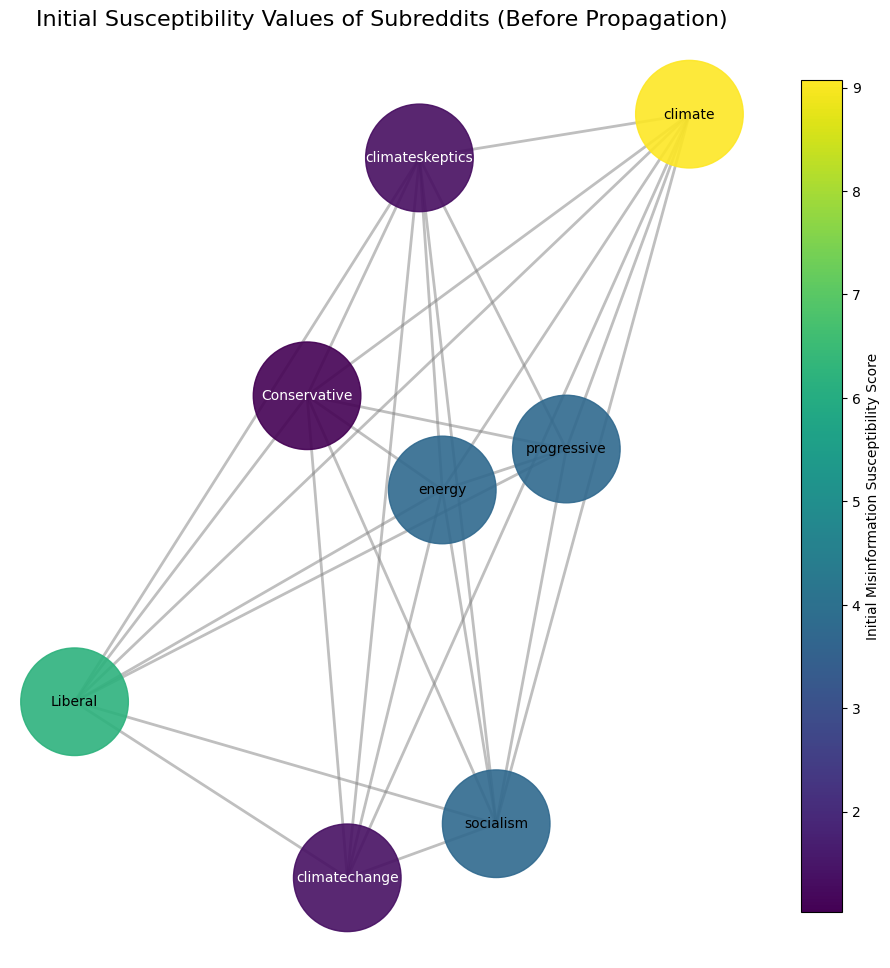

In [86]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Extract the initial scores for visualization
node_scores = [G.nodes[n]['score'] for n in G.nodes()]

# Set up colormap and normalization for node colors based on initial scores
node_cmap = plt.cm.viridis
score_min = min(node_scores) if node_scores else 0.0
score_max = max(node_scores) if node_scores else 1.0
norm = mcolors.Normalize(vmin=score_min, vmax=score_max)
node_colors = [node_cmap(norm(s)) for s in node_scores]

# Lay out the graph
pos = nx.spring_layout(G, seed=42)

# Assign font colors based on some condition (similar to the final scores code)
font_colors = {node: 'white' if node in ["climateskeptics", "Conservative", "climatechange"] else 'black' for node in G.nodes()}
node_labels = {node: node for node in G.nodes()}  # Labels are just the node names here

# Draw the nodes with colors mapped to their initial scores
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=6000, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2, alpha=0.5)

# Draw node labels with customized font colors
for node, label in node_labels.items():
    nx.draw_networkx_labels(
        G, pos,
        labels={node: label},
        font_size=10,
        font_color=font_colors[node]
    )

# Add a colorbar to interpret the node colors
sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=norm)
sm.set_array(node_scores)
plt.colorbar(sm, label='Initial Misinformation Susceptibility Score', shrink=0.9)

plt.title("Initial Susceptibility Values of Subreddits (Before Propagation)", fontsize=16)
plt.axis('off')
plt.show()

In [79]:
# Propagation parameters
max_iterations = 1000
convergence_threshold = 0.01
learning_rate = 0.01  # Small factor controlling the influence of the neighbor contribution

# Propagation loop
for iteration in range(max_iterations):
    new_scores = {}
    max_change = 0

    # Update each node's score based on its neighbors and current value
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        current_score = G.nodes[node]['score']

        if not neighbors:
            new_scores[node] = current_score  # No change for isolated nodes
            continue

        # Calculate the weighted sum of neighbors' scores
        neighbor_scores = [
            G.nodes[neighbor]['score'] * G[node][neighbor]['weight'] for neighbor in neighbors
        ]
        neighbor_contribution = np.mean(neighbor_scores)  # Average score of neighbors

        # Update score incrementally
        new_score = current_score + learning_rate * (neighbor_contribution - current_score)

        # Record the new score and calculate the change
        new_scores[node] = new_score
        max_change = max(max_change, abs(new_score - current_score))

    # Update scores in the graph
    for node, score in new_scores.items():
        G.nodes[node]['score'] = score

    # Check for convergence
    print(f"Iteration {iteration + 1}: Max change = {max_change:.4f}")
    if max_change < convergence_threshold:
        print("Propagation has converged!")
        break
else:
    print("Max iterations reached without full convergence.")

Iteration 1: Max change = 0.0906
Iteration 2: Max change = 0.0897
Iteration 3: Max change = 0.0888
Iteration 4: Max change = 0.0879
Iteration 5: Max change = 0.0870
Iteration 6: Max change = 0.0862
Iteration 7: Max change = 0.0853
Iteration 8: Max change = 0.0844
Iteration 9: Max change = 0.0836
Iteration 10: Max change = 0.0828
Iteration 11: Max change = 0.0819
Iteration 12: Max change = 0.0811
Iteration 13: Max change = 0.0803
Iteration 14: Max change = 0.0795
Iteration 15: Max change = 0.0787
Iteration 16: Max change = 0.0779
Iteration 17: Max change = 0.0771
Iteration 18: Max change = 0.0764
Iteration 19: Max change = 0.0756
Iteration 20: Max change = 0.0749
Iteration 21: Max change = 0.0741
Iteration 22: Max change = 0.0734
Iteration 23: Max change = 0.0726
Iteration 24: Max change = 0.0719
Iteration 25: Max change = 0.0712
Iteration 26: Max change = 0.0705
Iteration 27: Max change = 0.0698
Iteration 28: Max change = 0.0691
Iteration 29: Max change = 0.0684
Iteration 30: Max chang

In [80]:
# Save final scores
final_scores = {node: 1/data['score'] for node, data in G.nodes(data=True)}
final_scores_df = pd.DataFrame(list(final_scores.items()), columns=['subreddit', 'final_score'])
final_scores_df.to_csv('final_subreddit_scores.csv', index=False)
print("Final scores saved to 'final_subreddit_scores.csv'")

Final scores saved to 'final_subreddit_scores.csv'


/tmp/ipykernel_24/2850659148.py:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Edge Weight', shrink=0.9)
/tmp/ipykernel_24/2850659148.py:70: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm_nodes, label='Node Final Scores', shrink=0.9)


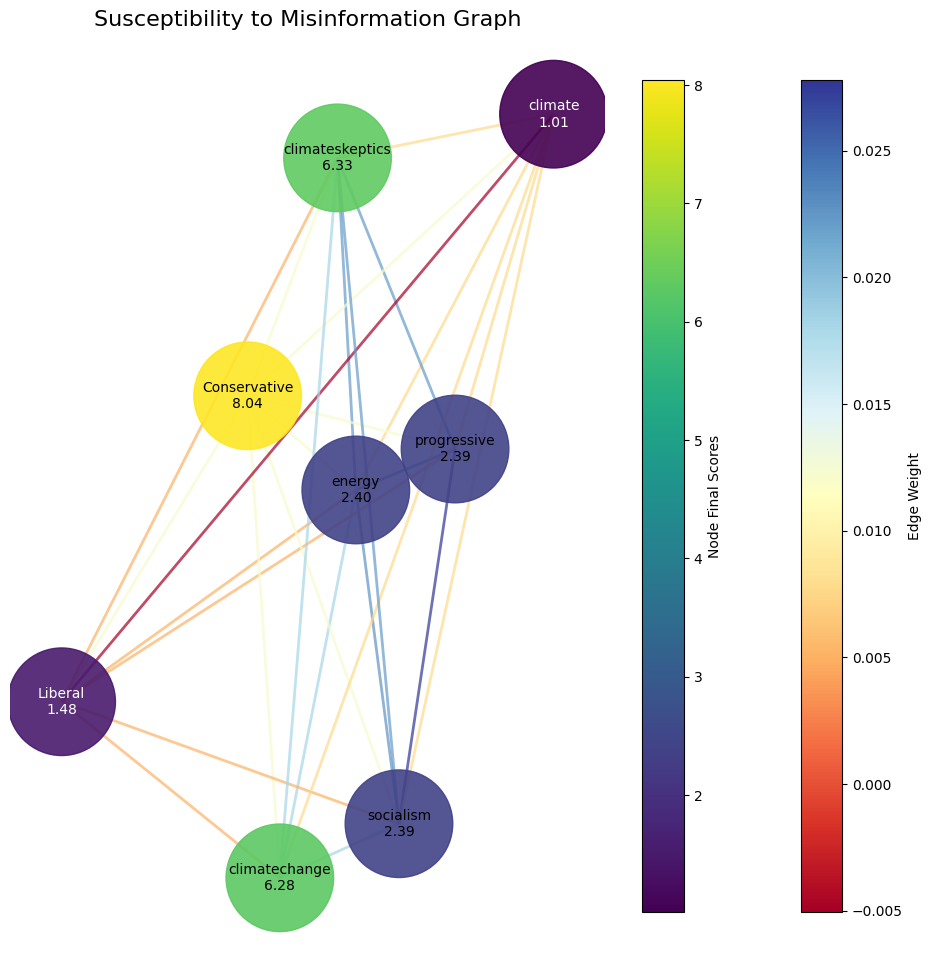

In [81]:
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx

# Load the final scores
final_scores = pd.read_csv('final_subreddit_scores.csv')  # Ensure this matches your saved file name
final_scores_dict = dict(zip(final_scores['subreddit'], final_scores['final_score']))

# Add final scores to node attributes
for node in G.nodes():
    G.nodes[node]['final_score'] = final_scores_dict.get(node, 0.0)  # Default to 0.0 for nodes without scores

# Prepare for visualization
weights = [G[u][v]['weight'] for u, v in G.edges()]
node_scores = [G.nodes[n]['final_score'] for n in G.nodes()]  # Node colors based on final scores

# Normalize weights for edges
cmap = plt.cm.RdYlBu  # Define colormap for edges
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))  # Normalize weights

# Normalize node scores for color mapping
node_cmap = plt.cm.viridis  # Define colormap for nodes
node_colors = [node_cmap((score - min(node_scores)) / (max(node_scores) - min(node_scores))) for score in node_scores]

# Prepare node labels with final scores
node_labels = {node: f"{node}\n{G.nodes[node]['final_score']:.2f}" for node in G.nodes()}

# Draw the graph
plt.figure(figsize=(12, 12))  # Set the figure size for better visibility
pos = nx.spring_layout(G, seed=42)  # Use spring layout to position nodes

# Draw nodes with customized color based on final scores
nx.draw_networkx_nodes(
    G, pos,
    node_size=6000,
    node_color=node_colors,  # Use pre-mapped colors
    alpha=0.9
)

# Draw edges with color mapped to weights
nx.draw_networkx_edges(
    G, pos,
    edge_color=weights,
    edge_cmap=cmap,
    edge_vmin=min(weights),
    edge_vmax=max(weights),
    width=2,
    alpha=0.7
)

font_colors = {node: 'white' if node in ["climate", "Liberal"] else 'black' for node in G.nodes()}
# Draw node labels with customized font colors
for node, label in node_labels.items():
    nx.draw_networkx_labels(
        G, pos,
        labels={node: label},
        font_size=10,
        font_color=font_colors[node]
    )

# Add colorbar for edge weights
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(weights)
plt.colorbar(sm, label='Edge Weight', shrink=0.9)

# Add colorbar for node scores
sm_nodes = plt.cm.ScalarMappable(cmap=node_cmap, norm=mcolors.Normalize(vmin=min(node_scores), vmax=max(node_scores)))
sm_nodes.set_array(node_scores)
plt.colorbar(sm_nodes, label='Node Final Scores', shrink=0.9)

# Show the graph
plt.title("Susceptibility to Misinformation Graph", fontsize=16)
plt.axis('off')  # Turn off axis
plt.show()